In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [2]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='AMZN'
stock_parameter ='Daily gain'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)
stock['Daily gain']=stock['Adj Close'].pct_change(1)
stock=stock.dropna(axis=0)
stock

,High,Low,Open,Close,Volume,Adj Close,Daily gain
Date,,,,,,,
2019-05-07,1949.099976,1903.380005,1939.989990,1921.000000,5902100,1921.000000,-0.015150
2019-05-08,1935.369995,1910.000000,1918.869995,1917.770020,4078600,1917.770020,-0.001681
2019-05-09,1909.400024,1876.000000,1900.000000,1899.869995,5308300,1899.869995,-0.009334
2019-05-10,1903.790039,1856.000000,1898.000000,1889.979980,5718000,1889.979980,-0.005206
2019-05-13,1846.540039,1818.000000,1836.560059,1822.680054,5783400,1822.680054,-0.035609
...,...,...,...,...,...,...,...
2020-04-27,2444.879883,2363.000000,2443.199951,2376.000000,5645600,2376.000000,-0.014198
2020-04-28,2373.500000,2306.000000,2372.100098,2314.080078,5269400,2314.080078,-0.026061
2020-04-29,2391.889893,2310.000000,2330.010010,2372.709961,4591600,2372.709961,0.025336


In [3]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [4]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

In [10]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(1, input_shape=(length, n_features)))
model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [12]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [13]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 211 steps, validate for 1 steps
Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 0.0461 - val_loss: 0.2672
Epoch 2/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0214 - val_loss: 0.2473
Epoch 3/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0173 - val_loss: 0.2172
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0162 - val_loss: 0.2609
Epoch 5/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0154 - val_loss: 0.2566
Epoch 6/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0151 - val_loss: 0.2672
Epoch 7/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0150 - val_loss: 0.2584
Epoch 8/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0147 - val_loss: 0.2664
Epoch 9/50
211/211 [===========

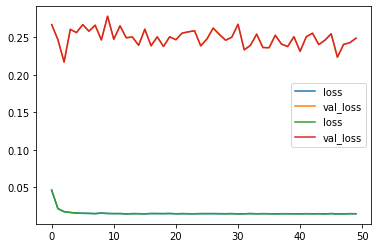

In [14]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [15]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [16]:
true_predictions =scaler.inverse_transform(test_predictions)


In [17]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

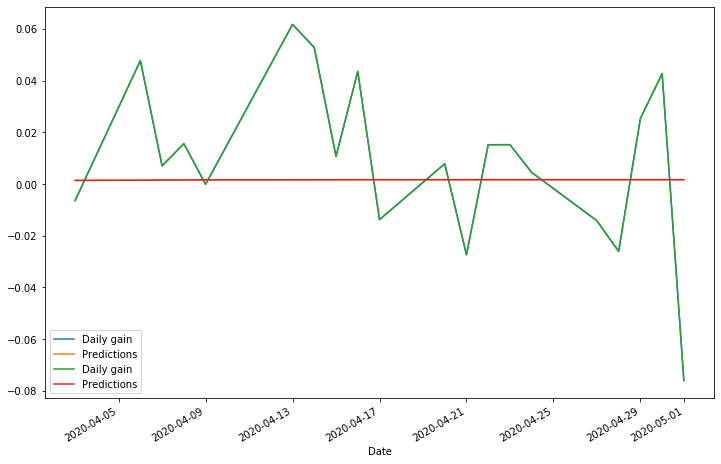

In [18]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [19]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

Using TensorFlow backend.


# Forecasting

In [20]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [21]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [22]:
forecast_model= Sequential()
forecast_model.add(Dense(1, input_shape=(length, n_features)))
forecast_model.add(LSTM(64))
forecast_model.add(Flatten())
forecast_model.add(Dense(512, activation='sigmoid'))
forecast_model.add(Dropout(0.4))
forecast_model.add(Dense(32, activation='sigmoid'))
forecast_model.add(Dense(1))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 231 steps
Epoch 1/50
231/231 [==============================] - 3s 14ms/step - loss: 0.0437
Epoch 2/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0218
Epoch 3/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0215
Epoch 4/50
231/231 [==============================] - 1s 6ms/step - loss: 0.0190
Epoch 5/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0188
Epoch 6/50
231/231 [==============================] - 1s 6ms/step - loss: 0.0177
Epoch 7/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0179
Epoch 8/50
231/231 [==============================] - 1s 6ms/step - loss: 0.0176
Epoch 9/50
231/231 [==============================] - 1s 6ms/step - loss: 0.0177
Epoch 10/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0177
Epoch 11/50
231/231 [==============================] - 2s 8ms/step - loss: 0.0175
Epoch 12/50
231/231 [==============================] - 2s 8ms

In [23]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [24]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [25]:
forecast = scaler.inverse_transform(forecast)

In [26]:
forecast

array([[0.0020704 ],
       [0.00198384],
       [0.00190353],
       [0.00184451],
       [0.00180057],
       [0.00176832],
       [0.00174509],
       [0.00172742],
       [0.00171522],
       [0.00170467],
       [0.00169741],
       [0.00169104],
       [0.00168766],
       [0.00168522],
       [0.00168303],
       [0.00168098],
       [0.00167897],
       [0.00167923],
       [0.00168   ]])

In [27]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [28]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

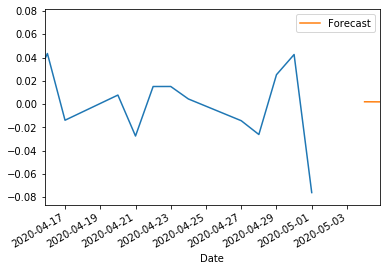

In [29]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [30]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')